In [1]:
import cv2
import os
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from sklearn.utils import shuffle
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Flatten
from tensorflow.keras.applications.vgg16 import VGG16
np.random.seed(0)
tf.compat.v1.random.set_random_seed(0)

In [2]:
fakepath = '/kaggle/input/model-training-dataset/fake/'
originalpath = "/kaggle/input/model-training-dataset/original/"
fake = []
original = []

# **Pipeline**

In [3]:
for name in tqdm(os.listdir(fakepath)):
    for frame in os.listdir(fakepath + name):
        fake.append(fakepath + name + '/' + frame)

100%|██████████| 1481/1481 [00:02<00:00, 580.13it/s]


In [4]:
for name in tqdm(os.listdir(originalpath)):
    for frame in os.listdir(originalpath + name):
        original.append(originalpath + name + '/' + frame)

100%|██████████| 362/362 [00:01<00:00, 296.24it/s]


In [5]:
y = np.ones(len(original))
x = np.zeros(len(fake))
label = np.concatenate([y, x])
names_list = original + fake
new_data, new_label = shuffle(names_list, label,  random_state = 0)
train, test, y_train, y_test = new_data[:-100], new_data[-100:], new_label[:-100], new_label[-100:]

In [6]:
def decode_img(img):
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32) 
    img = tf.image.random_flip_left_right(img)
    img = tf.image.random_flip_up_down(img)
    img = tf.image.random_saturation(img, 1, 3)
    img = tf.image.random_brightness(img, 0.3)
    return img

def get_label(file_path):
    cat = tf.strings.split(file_path, '/')[4]
    if cat == b'fake':
        return 1
    return 0

def process_path(file_path):
    label = get_label(file_path)
    img = tf.io.read_file(file_path)
    img = decode_img(img)
    return img, label

In [7]:
num_threads, num_epochs, train_len = 5, 3000, len(train) 
train_ds = tf.data.Dataset.from_tensor_slices(train)
train_ds = train_ds.map(process_path, num_parallel_calls=tf.data.experimental.AUTOTUNE)

In [8]:
train_ds = train_ds.shuffle(train_len)
train_ds = train_ds.batch(64)
train_ds = train_ds.prefetch(1)

In [9]:
from tensorflow.keras.applications.vgg16 import VGG16
model = VGG16(weights='imagenet', include_top=False, input_shape=(64, 64, 3))
for layer in model.layers[:5]:
    layer.trainable = False

58892288/58889256 [==============================] - 1s 0us/step


In [13]:
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-1,
    decay_steps=10,
    decay_rate=0.9)
opt = tf.keras.optimizers.Adam(
    learning_rate= lr_schedule,
    beta_1=0.9,
    beta_2=0.999,
    epsilon=1e-07,
    amsgrad=False)
def loss_fn(labels, predictions):
    return tf.math.confusion_matrix(
    labels, predictions, num_classes=2, weights=None, dtype=tf.dtypes.int32,
    name=None).numpy()[0,1]
tp = tf.keras.metrics.TruePositives(thresholds=None, name=None, dtype=None)
tn = tf.keras.metrics.TrueNegatives(thresholds=None, name=None, dtype=None)
fp = tf.keras.metrics.FalsePositives(thresholds=None, name=None, dtype=None)
fn = tf.keras.metrics.FalseNegatives(thresholds=None, name=None, dtype=None)

In [16]:
classifier = Sequential()
classifier.add(model)
classifier.add(Flatten())
classifier.add(Dense(1024, activation='relu'))
classifier.add(Dense(1, activation = 'sigmoid'))
classifier.compile(optimizer = opt, loss = 'binary_crossentropy', metrics = ['accuracy', tp,tn,fp,fn])

In [17]:
history = classifier.fit(train_ds, epochs = 20, shuffle=True, batch_size=64)

Epoch 1/20
944/944 [==============================] - 37s 39ms/step - loss: 0.6544 - accuracy: 0.7803 - true_positives_1: 47068.0000 - true_negatives_1: 68.0000 - false_positives_1: 13081.0000 - false_negatives_1: 188.0000
Epoch 2/20
944/944 [==============================] - 37s 39ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positives_1: 47256.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 13149.0000 - false_negatives_1: 0.0000e+00
Epoch 3/20
944/944 [==============================] - 37s 39ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positives_1: 47256.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 13149.0000 - false_negatives_1: 0.0000e+00
Epoch 4/20
944/944 [==============================] - 36s 38ms/step - loss: 0.5240 - accuracy: 0.7823 - true_positives_1: 47256.0000 - true_negatives_1: 0.0000e+00 - false_positives_1: 13149.0000 - false_negatives_1: 0.0000e+00
Epoch 5/20
944/944 [==============================] - 36s 39ms/step - loss: 0.5240 - accuracy

In [18]:
import matplotlib.pyplot as plt

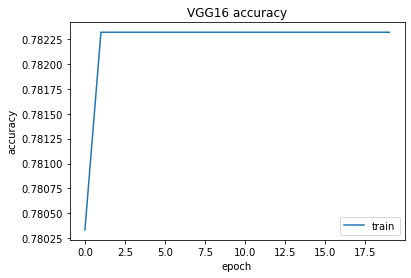

In [21]:
plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.title('VGG16 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')
plt.show()

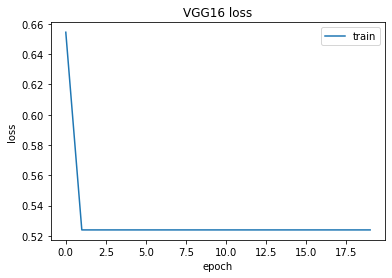

In [22]:
plt.plot(history.history['loss'])
# plt.plot(history.history['val_loss'])
plt.title('VGG16 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')
plt.show()